# VQA-RAD — Final Evaluation Sanity Check (BLIP-2 + Flan-T5-XL)


VQA pipeline on a small, reproducible subset of `flaviagiammarino/vqa-rad`.

## Imports & Config

**NVIDIA A10 (24GB VRAM) Optimized Settings:**

Key changes from RTX 2070 configuration:
1. **Batch Size:** 1 → 4 (A10 has 3x more VRAM)
2. **Gradient Accumulation:** 16 → 4 (effective batch = 16 remains optimal)
3. **Learning Rate:** 2e-5 → 5e-5 (adjusted for larger effective updates)
4. **Gradient Checkpointing:** Disabled (causes conflicts with PEFT LoRA)
5. **Gradient Clipping:** Added MAX_GRAD_NORM=1.0 to prevent NaN loss
6. **NUM_WORKERS:** 0 → 2 (parallel data loading)
7. **Weight Decay:** Added 0.01 for better regularization

**NaN Loss Fixes:**
- Gradient clipping prevents exploding gradients
- NaN detection and batch skipping
- Proper GradScaler handling for bfloat16 (A10 supports bf16)
- Weight decay for stability

**Note:** Gradient checkpointing disabled because it conflicts with PEFT LoRA. The A10's 24GB VRAM is sufficient without it.

Define a small, explicit experiment configuration for reproducibility and straightforward review. Install dependencies from `requirements.txt` before running.

In [1]:
import torch
torch.cuda.empty_cache()


In [2]:
import os
import json
import random
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
from dataclasses import dataclass
from pathlib import Path
from typing import Any, Dict, List, Tuple
import matplotlib.pyplot as plt
import numpy as np
import torch
from datasets import load_dataset
from PIL import Image
from sacrebleu.metrics import BLEU
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from transformers import Blip2ForConditionalGeneration, Blip2Processor
from peft import LoraConfig, get_peft_model

os.environ.setdefault("TOKENIZERS_PARALLELISM", "false")

DATASET_NAME = "flaviagiammarino/vqa-rad"
SPLITS_PATH = Path("vqarad_subset_splits.json")

SEED = 1337
SUBSET_FRAC = 1.0
VAL_FRAC = 0.15
TEST_FRAC = 0.15

# NVIDIA A10 (24GB VRAM) Optimized Settings
EPOCHS = 20
BATCH_SIZE = 4 
GRAD_ACCUM_STEPS = 6
LR = 2e-5 
NUM_WORKERS = 2  # Enable parallel data loading

# Early stopping & checkpointing
EARLY_STOP_PATIENCE = 6
CHECKPOINT_DIR = Path("checkpoints")
CHECKPOINT_DIR.mkdir(exist_ok=True)

# Memory-efficient flags optimized for A10
USE_8BIT = False  
USE_GRADIENT_CHECKPOINTING = False  # Disabled: causes issues with PEFT LoRA in this setup

# Gradient clipping to prevent NaN loss
MAX_GRAD_NORM = 1.0  # Clip gradients to prevent exploding gradients

def set_seed(seed: int) -> None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

def get_device() -> str:
    if torch.cuda.is_available():
        return "cuda"
    if getattr(torch.backends, "mps", None) is not None and torch.backends.mps.is_available():
        return "mps"
    return "cpu"

def get_dtype(device: str) -> torch.dtype:
    if device in {"cuda", "mps"}:
        if device == "cuda" and torch.cuda.is_bf16_supported():
            return torch.bfloat16
        return torch.float16
    return torch.float32

device = get_device()
dtype = get_dtype(device)
set_seed(SEED)

print(f"device={device} dtype={dtype} | subset_frac={SUBSET_FRAC} | epochs={EPOCHS} batch={BATCH_SIZE} accum={GRAD_ACCUM_STEPS} lr={LR}")
print(f"8bit={USE_8BIT} grad_ckpt={USE_GRADIENT_CHECKPOINTING} max_grad_norm={MAX_GRAD_NORM}")
print(f"torch={torch.__version__} | torch.version.cuda={torch.version.cuda} | cuda_available={torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"cuda_device={torch.cuda.get_device_name(0)}")
    # Log initial VRAM state
    torch.cuda.reset_peak_memory_stats()
    torch.cuda.empty_cache()  # Clear cache before starting
    allocated = torch.cuda.memory_allocated() / 1e9
    reserved = torch.cuda.memory_reserved() / 1e9
    print(f"Initial VRAM: allocated={allocated:.2f}GB reserved={reserved:.2f}GB")

/home/teras/Software/Jupyter/LLMs/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


device=cuda dtype=torch.bfloat16 | subset_frac=1.0 | epochs=20 batch=4 accum=6 lr=2e-05
8bit=False grad_ckpt=False max_grad_norm=1.0
torch=2.9.1+cu128 | torch.version.cuda=12.8 | cuda_available=True
cuda_device=NVIDIA A10
Initial VRAM: allocated=0.00GB reserved=0.00GB


## Dataset Loading & Preprocessing


Load a single cached subset split so both notebooks operate on the exact same examples.

In [3]:
def normalize_text(s: str) -> str:
    s = s.lower().strip()
    return " ".join(s.split())

def token_f1(prediction: str, ground_truth: str) -> float:
    pred_tokens = normalize_text(prediction).split()
    gt_tokens = normalize_text(ground_truth).split()
    if len(pred_tokens) == 0 and len(gt_tokens) == 0:
        return 1.0
    if len(pred_tokens) == 0 or len(gt_tokens) == 0:
        return 0.0
    common: Dict[str, int] = {}
    for t in pred_tokens:
        common[t] = common.get(t, 0) + 1
    overlap = 0
    for t in gt_tokens:
        if common.get(t, 0) > 0:
            overlap += 1
            common[t] -= 1
    if overlap == 0:
        return 0.0
    precision = overlap / len(pred_tokens)
    recall = overlap / len(gt_tokens)
    return 2 * precision * recall / (precision + recall)

def load_or_create_subset_splits(
    dataset_name: str,
    *,
    subset_frac: float,
    seed: int,
    val_frac: float,
    test_frac: float,
    path: Path,
    force_regen: bool = False,
 ):
    ds = load_dataset(dataset_name, split="train").shuffle(seed=seed)
    subset_size = max(3, int(len(ds) * subset_frac))
    subset_size = min(subset_size, len(ds))

    cfg = {
        "dataset_name": dataset_name,
        "seed": int(seed),
        "subset_frac": float(subset_frac),
        "val_frac": float(val_frac),
        "test_frac": float(test_frac),
        "subset_size": int(subset_size),
    }

    def make_indices() -> Dict[str, List[int]]:
        rng = np.random.RandomState(seed)
        perm = rng.permutation(subset_size).tolist()
        n_val = max(1, int(round(subset_size * val_frac)))
        n_test = max(1, int(round(subset_size * test_frac)))
        n_train = subset_size - n_val - n_test
        if n_train < 1:
            n_train = 1
            remain = subset_size - n_train
            n_val = max(1, min(n_val, max(1, remain - 1)))
            n_test = max(1, remain - n_val)
        return {
            "train": perm[:n_train],
            "val": perm[n_train : n_train + n_val],
            "test": perm[n_train + n_val :],
        }

    if path.exists() and not force_regen:
        cached = json.loads(path.read_text(encoding="utf-8"))
        old_cfg = cached.get("config", {})
        same_cfg = all(old_cfg.get(k) == cfg.get(k) for k in cfg.keys())
        indices = cached["indices"] if same_cfg else make_indices()
        if not same_cfg:
            path.write_text(json.dumps({"config": cfg, "indices": indices}, indent=2), encoding="utf-8")
    else:
        indices = make_indices()
        path.write_text(json.dumps({"config": cfg, "indices": indices}, indent=2), encoding="utf-8")

    train_ds = ds.select(indices["train"])
    val_ds = ds.select(indices["val"])
    test_ds = ds.select(indices["test"])
    return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = load_or_create_subset_splits(
    DATASET_NAME,
    subset_frac=SUBSET_FRAC,
    seed=SEED,
    val_frac=VAL_FRAC,
    test_frac=TEST_FRAC,
    path=SPLITS_PATH,
)
print(f"subset sizes | train={len(train_ds)} val={len(val_ds)} test={len(test_ds)}")

subset sizes | train=1255 val=269 test=269


## Model Definition


Instantiate the same BLIP-2 checkpoint and attach LoRA adapters to the Q-Former; this keeps the architecture unchanged while limiting trainable parameters.

## Precompute Visual Embeddings (Optional)

Cache image embeddings to disk to avoid repeated vision encoder forward passes during training. This reduces VRAM usage and speeds up training when using the same dataset multiple times.

In [4]:
import pickle
from typing import Optional

CACHE_DIR = Path("cache_embeddings")
CACHE_DIR.mkdir(exist_ok=True)

@torch.no_grad()
def precompute_vision_embeddings(
    model: torch.nn.Module,
    dataset: Dataset,
    cache_path: Path,
    batch_size: int = 4,
) -> None:
    """
    Precompute and cache vision embeddings to disk.
    Reduces VRAM during training by avoiding repeated vision encoder forward passes.
    """
    if cache_path.exists():
        print(f"Cache already exists at {cache_path}, skipping precomputation.")
        return
    
    model.eval()
    embeddings = []
    
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    for batch in tqdm(loader, desc="Precomputing vision embeddings"):
        images = [ex["image"] for ex in batch] if isinstance(batch, list) else batch["image"]
        if not isinstance(images, list):
            images = [images]
        
        enc = processor(images=images, return_tensors="pt")
        pixel_values = enc["pixel_values"].to(device)
        
        # Extract vision embeddings from Q-Former
        if hasattr(model, "get_vision_embeddings"):
            vision_embeds = model.get_vision_embeddings(pixel_values)
        elif hasattr(model.base_model, "get_qformer_features"):
            vision_embeds = model.base_model.get_qformer_features(pixel_values)[0]
        else:
            # Fallback: extract from vision model
            vision_embeds = model.base_model.vision_model(pixel_values)[0]
        
        embeddings.append(vision_embeds.cpu())
    
    embeddings = torch.cat(embeddings, dim=0)
    with open(cache_path, "wb") as f:
        pickle.dump(embeddings, f)
    print(f"Saved {len(embeddings)} embeddings to {cache_path} ({cache_path.stat().st_size / 1e6:.1f}MB)")

# Uncomment to precompute embeddings (optional for memory savings)
# precompute_vision_embeddings(model, train_dataset, CACHE_DIR / "train_embeddings.pkl", batch_size=4)
# precompute_vision_embeddings(model, val_dataset, CACHE_DIR / "val_embeddings.pkl", batch_size=4)
# precompute_vision_embeddings(model, test_dataset, CACHE_DIR / "test_embeddings.pkl", batch_size=4)

print("Visual embedding precomputation cell ready (uncomment to use).")

Visual embedding precomputation cell ready (uncomment to use).


In [5]:
CKPT = "Salesforce/blip2-flan-t5-xl"

processor = Blip2Processor.from_pretrained(CKPT)

# A10 has 24GB VRAM - no need for 8-bit quantization
if USE_8BIT and device == "cuda":
    base_model = Blip2ForConditionalGeneration.from_pretrained(
        CKPT,
        load_in_8bit=True,
        device_map="auto",
    )
else:
    base_model = Blip2ForConditionalGeneration.from_pretrained(CKPT, torch_dtype=dtype)
    base_model = base_model.to(device)

# Freeze vision encoder to save VRAM during training
if hasattr(base_model, "vision_model"):
    for p in base_model.vision_model.parameters():
        p.requires_grad = False

def infer_qformer_lora_targets(model: torch.nn.Module) -> List[str]:
    """Find attention projection layers in Q-Former for LoRA adaptation."""
    targets: set[str] = set()
    for name, module in model.named_modules():
        lname = name.lower()
        if "qformer" not in lname:
            continue
        if not isinstance(module, torch.nn.Linear):
            continue
        if any(k in lname for k in ["query", "key", "value", "q_proj", "k_proj", "v_proj", "out_proj", "dense"]):
            targets.add(name.split(".")[-1])
    return sorted(targets) if targets else ["query", "key", "value"]

# LoRA configuration optimized for A10
lora_cfg = LoraConfig(
    r=24, 
    lora_alpha=48,
    lora_dropout=0.1,
    bias="none",
    task_type="SEQ_2_SEQ_LM",
    target_modules=infer_qformer_lora_targets(base_model),
)

model = get_peft_model(base_model, lora_cfg)

# Gradient checkpointing disabled - conflicts with PEFT LoRA
# A10 has 24GB VRAM which is sufficient for training without gradient checkpointing
if USE_GRADIENT_CHECKPOINTING:
    print("Warning: Gradient checkpointing disabled (conflicts with PEFT LoRA)")
    print("A10 24GB VRAM is sufficient for batch_size=4 without gradient checkpointing")

def count_trainable_params(m: torch.nn.Module) -> Tuple[int, int]:
    trainable = sum(p.numel() for p in m.parameters() if p.requires_grad)
    total = sum(p.numel() for p in m.parameters())
    return trainable, total

trainable, total = count_trainable_params(model)
pct = 100.0 * trainable / max(1, total)
print(f"trainable params: {trainable:,} / {total:,} ({pct:.4f}%)")

if torch.cuda.is_available():
    allocated = torch.cuda.memory_allocated() / 1e9
    reserved = torch.cuda.memory_reserved() / 1e9
    print(f"After model load: allocated={allocated:.2f}GB reserved={reserved:.2f}GB")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
`torch_dtype` is deprecated! Use `dtype` instead!
Loading checkpoint shards: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.44s/it]


trainable params: 5,050,368 / 3,947,496,960 (0.1279%)
After model load: allocated=7.91GB reserved=7.91GB


In [6]:
# Debug: Check which parameters require grad
trainable_param_names = [name for name, p in model.named_parameters() if p.requires_grad]
print(f"\nTrainable parameters ({len(trainable_param_names)}):")
for name in trainable_param_names[:10]:  # Show first 10
    print(f"  {name}")
if len(trainable_param_names) > 10:
    print(f"  ... and {len(trainable_param_names) - 10} more")


Trainable parameters (192):
  base_model.model.qformer.encoder.layer.0.attention.attention.query.lora_A.default.weight
  base_model.model.qformer.encoder.layer.0.attention.attention.query.lora_B.default.weight
  base_model.model.qformer.encoder.layer.0.attention.attention.key.lora_A.default.weight
  base_model.model.qformer.encoder.layer.0.attention.attention.key.lora_B.default.weight
  base_model.model.qformer.encoder.layer.0.attention.attention.value.lora_A.default.weight
  base_model.model.qformer.encoder.layer.0.attention.attention.value.lora_B.default.weight
  base_model.model.qformer.encoder.layer.0.attention.output.dense.lora_A.default.weight
  base_model.model.qformer.encoder.layer.0.attention.output.dense.lora_B.default.weight
  base_model.model.qformer.encoder.layer.0.crossattention.attention.query.lora_A.default.weight
  base_model.model.qformer.encoder.layer.0.crossattention.attention.query.lora_B.default.weight
  ... and 182 more


## Training Data Interface


Wrap the dataset and define a collate function that builds BLIP-2 inputs and teacher-forced labels.

In [7]:
class VqaRadImageQADataset(Dataset):
    def __init__(self, hf_ds):
        self.ds = hf_ds

    def __len__(self) -> int:
        return len(self.ds)

    def __getitem__(self, idx: int) -> Dict[str, Any]:
        ex = self.ds[idx]
        return {
            "image": ex["image"].convert("RGB"),
            "question": ex["question"],
            "answer": ex["answer"],
        }

@dataclass
class Blip2Batch:
    pixel_values: torch.Tensor
    input_ids: torch.Tensor
    attention_mask: torch.Tensor
    labels: torch.Tensor
    raw_question: List[str]
    raw_answer: List[str]
    raw_image: List[Image.Image]

def format_qa_prompt(question: str) -> str:
    q = str(question).strip()
    return f"Question: {q} Answer:"

def make_blip2_collate(
    processor: Blip2Processor,
    *,
    max_question_len: int = 64,
    max_answer_len: int = 32,
 ):
    def collate(examples: List[Dict[str, Any]]) -> Blip2Batch:
        images = [e["image"] for e in examples]
        questions = [e["question"] for e in examples]
        answers = [e["answer"] for e in examples]

        prompts = [format_qa_prompt(q) for q in questions]
        enc = processor(
            images=images,
            text=prompts,
            padding=True,
            truncation=True,
            max_length=max_question_len,
            return_tensors="pt",
        )
        tgt = processor.tokenizer(
            answers,
            padding=True,
            truncation=True,
            max_length=max_answer_len,
            return_tensors="pt",
        )
        labels = tgt["input_ids"].clone()
        labels[labels == processor.tokenizer.pad_token_id] = -100
        return Blip2Batch(
            pixel_values=enc["pixel_values"],
            input_ids=enc["input_ids"],
            attention_mask=enc["attention_mask"],
            labels=labels,
            raw_question=questions,
            raw_answer=answers,
            raw_image=images,
        )
    return collate

train_dataset = VqaRadImageQADataset(train_ds)
val_dataset = VqaRadImageQADataset(val_ds)
test_dataset = VqaRadImageQADataset(test_ds)

collate_fn = make_blip2_collate(
    processor,
    max_question_len=48,
    max_answer_len=24,
 )

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    collate_fn=collate_fn,
 )
val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    collate_fn=collate_fn,
 )
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    collate_fn=collate_fn,
 )

## Training Loop (Minimal)


Run a small number of epochs with a single optimizer setup

In [8]:
GEN_KWARGS = dict(
    max_new_tokens=32,
    min_new_tokens=1,
    do_sample=False,
    num_beams=2,
    pad_token_id=processor.tokenizer.pad_token_id,
    eos_token_id=processor.tokenizer.eos_token_id,
)

def train_epochs(
    model: torch.nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    *,
    epochs: int,
    lr: float,
    grad_accum_steps: int = 1,
    use_amp: bool = True,
    early_stop_patience: int = 3,
    checkpoint_dir: Path = Path("checkpoints"),
):
    """
    Train with gradient accumulation, mixed precision, early stopping, and checkpointing.
    - Gradient accumulation: simulate larger batch size without memory overhead
    - AMP (Automatic Mixed Precision): use fp16/bf16 for faster compute and lower VRAM
    - Early stopping: stop training if validation metric doesn't improve for N epochs
    - Checkpointing: save best model based on validation BLEU
    - Gradient clipping: prevent NaN loss from exploding gradients
    """
    model.train()
    opt = torch.optim.AdamW([p for p in model.parameters() if p.requires_grad], lr=lr, weight_decay=0.01)
    
    # Mixed precision scaler for fp16 training (memory + speed boost)
    # Use GradScaler only for fp16, not bfloat16
    use_scaler = use_amp and device == "cuda" and dtype == torch.float16
    scaler = torch.cuda.amp.GradScaler() if use_scaler else None
    
    # Early stopping tracking
    best_val_bleu = -1.0
    epochs_without_improvement = 0
    best_checkpoint_path = checkpoint_dir / "best_model.pt"
    
    def load_best_checkpoint() -> None:
        if not best_checkpoint_path.exists():
            print("No checkpoint found; skipping restore.")
            return
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        checkpoint = torch.load(best_checkpoint_path, map_location="cpu")
        model.load_state_dict(checkpoint["model_state_dict"])
        del checkpoint
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
    
    for epoch in range(1, epochs + 1):
        # Training phase
        model.train()
        pbar = tqdm(train_loader, desc=f"[train] epoch {epoch}/{epochs}")
        running_loss = 0.0
        steps = 0
        nan_count = 0
        
        opt.zero_grad(set_to_none=True)
        
        for batch_idx, batch in enumerate(pbar):
            # Mixed precision forward pass
            if use_amp and device == "cuda":
                with torch.amp.autocast('cuda', dtype=dtype):
                    out = model(
                        pixel_values=batch.pixel_values.to(device),
                        input_ids=batch.input_ids.to(device),
                        attention_mask=batch.attention_mask.to(device),
                        labels=batch.labels.to(device),
                    )
                    loss = out.loss / grad_accum_steps  # Scale loss for accumulation
            else:
                out = model(
                    pixel_values=batch.pixel_values.to(device),
                    input_ids=batch.input_ids.to(device),
                    attention_mask=batch.attention_mask.to(device),
                    labels=batch.labels.to(device),
                )
                loss = out.loss / grad_accum_steps
            
            # Check for NaN loss
            if torch.isnan(loss) or torch.isinf(loss):
                nan_count += 1
                print(f"\nWarning: NaN/Inf loss detected at batch {batch_idx}. Skipping batch.")
                opt.zero_grad(set_to_none=True)
                continue
            
            # Backward pass with gradient scaling
            if scaler is not None:
                scaler.scale(loss).backward()
            else:
                loss.backward()
            
            # Update weights every grad_accum_steps
            if (batch_idx + 1) % grad_accum_steps == 0:
                # Gradient clipping to prevent exploding gradients
                if scaler is not None:
                    scaler.unscale_(opt)
                    torch.nn.utils.clip_grad_norm_(model.parameters(), MAX_GRAD_NORM)
                    scaler.step(opt)
                    scaler.update()
                else:
                    torch.nn.utils.clip_grad_norm_(model.parameters(), MAX_GRAD_NORM)
                    opt.step()
                opt.zero_grad(set_to_none=True)
            
            running_loss += float(loss.item()) * grad_accum_steps
            steps += 1
            pbar.set_postfix(loss=float(loss.item()) * grad_accum_steps, nan_count=nan_count)
        
        mean_loss = running_loss / max(1, steps)
        
        if nan_count > 0:
            print(f"[epoch {epoch}] WARNING: {nan_count} NaN losses detected and skipped")
        
        # Validation phase
        val_bleu, val_f1 = evaluate_bleu_and_token_f1(model, val_loader, max_new_tokens=32)
        
        print(f"[epoch {epoch}] train_loss={mean_loss:.4f} | val_bleu={val_bleu:.2f} val_f1={val_f1:.3f}", end="")
        
        # Check for improvement
        if val_bleu > best_val_bleu:
            best_val_bleu = val_bleu
            epochs_without_improvement = 0
            # Save best model (weights-only on CPU to avoid GPU OOM)
            checkpoint = {
                "epoch": epoch,
                "model_state_dict": {k: v.detach().cpu() for k, v in model.state_dict().items()},
                "val_bleu": float(val_bleu),
                "val_f1": float(val_f1),
                "train_loss": float(mean_loss),
            }
            torch.save(checkpoint, best_checkpoint_path)
            print(f" [BEST - saved checkpoint]")
        else:
            epochs_without_improvement += 1
            print(f" [no improvement: {epochs_without_improvement}/{early_stop_patience}]")
        
        if torch.cuda.is_available():
            peak_mem = torch.cuda.max_memory_allocated() / 1e9
            print(f"  Peak VRAM: {peak_mem:.2f}GB")
        
        # Early stopping check
        if epochs_without_improvement >= early_stop_patience:
            print(f"\n[EARLY STOPPING] No improvement for {early_stop_patience} epochs.")
            print(f"Restoring best model from epoch {epoch - early_stop_patience} (val_bleu={best_val_bleu:.2f})")
            load_best_checkpoint()
            break
    
    # Load best model if training completed without early stopping
    if epochs_without_improvement < early_stop_patience:
        print(f"\nTraining complete. Loading best model (val_bleu={best_val_bleu:.2f})")
        load_best_checkpoint()
    
    return best_val_bleu

@torch.no_grad()
def evaluate_bleu_and_token_f1(
    model: torch.nn.Module,
    loader: DataLoader,
    *,
    max_new_tokens: int = 32,
 ):
    model.eval()
    bleu = BLEU(effective_order=True)
    all_predictions: List[str] = []
    all_refs: List[str] = []
    f1s: List[float] = []
    gen_kwargs = dict(GEN_KWARGS)
    gen_kwargs["max_new_tokens"] = max_new_tokens

    for batch in loader:
        gen_ids = model.generate(
            pixel_values=batch.pixel_values.to(device),
            input_ids=batch.input_ids.to(device),
            attention_mask=batch.attention_mask.to(device),
            **gen_kwargs,
        )
        predictions = processor.tokenizer.batch_decode(gen_ids, skip_special_tokens=True)
        predictions = [p.strip() if p.strip() else "<EMPTY>" for p in predictions]
        refs = [str(r) for r in batch.raw_answer]
        all_predictions.extend(predictions)
        all_refs.extend(refs)
        for p, r in zip(predictions, refs):
            f1s.append(token_f1(p, r))

    bleu_score = float(bleu.corpus_score(all_predictions, [all_refs]).score) if all_predictions else 0.0
    f1_score = float(np.mean(f1s)) if f1s else 0.0
    return bleu_score, f1_score

best_val_bleu = train_epochs(
    model, 
    train_loader, 
    val_loader,
    epochs=EPOCHS, 
    lr=LR, 
    grad_accum_steps=GRAD_ACCUM_STEPS, 
    use_amp=True,
    early_stop_patience=EARLY_STOP_PATIENCE,
    checkpoint_dir=CHECKPOINT_DIR,
)

print("\n" + "="*60)
print("FINAL EVALUATION WITH BEST MODEL")
print("="*60)

bleu_val, f1_val = evaluate_bleu_and_token_f1(model, val_loader)
bleu_test, f1_test = evaluate_bleu_and_token_f1(model, test_loader)
print(f"\n[FINAL RESULTS] val_bleu={bleu_val:.2f} val_token_f1={f1_val:.3f}")
print(f"[FINAL RESULTS] test_bleu={bleu_test:.2f} test_token_f1={f1_test:.3f}")

[train] epoch 1/20: 100%|██████████████████████████████████████████████████████████████████████████| 314/314 [02:11<00:00,  2.38it/s, loss=3.1, nan_count=0]


[epoch 1] train_loss=1.9821 | val_bleu=2.98 val_f1=0.345 [BEST - saved checkpoint]
  Peak VRAM: 8.93GB


[train] epoch 2/20: 100%|█████████████████████████████████████████████████████████████████████████| 314/314 [02:12<00:00,  2.37it/s, loss=0.67, nan_count=0]


[epoch 2] train_loss=1.7722 | val_bleu=2.08 val_f1=0.368 [no improvement: 1/6]
  Peak VRAM: 8.93GB


[train] epoch 3/20: 100%|█████████████████████████████████████████████████████████████████████████| 314/314 [02:14<00:00,  2.34it/s, loss=2.01, nan_count=0]


[epoch 3] train_loss=1.7047 | val_bleu=2.53 val_f1=0.432 [no improvement: 2/6]
  Peak VRAM: 8.93GB


[train] epoch 4/20: 100%|█████████████████████████████████████████████████████████████████████████| 314/314 [02:20<00:00,  2.23it/s, loss=2.05, nan_count=0]


[epoch 4] train_loss=1.6445 | val_bleu=2.86 val_f1=0.447 [no improvement: 3/6]
  Peak VRAM: 8.94GB


[train] epoch 5/20: 100%|████████████████████████████████████████████████████████████████████████| 314/314 [02:17<00:00,  2.28it/s, loss=0.872, nan_count=0]


[epoch 5] train_loss=1.6168 | val_bleu=4.23 val_f1=0.469 [BEST - saved checkpoint]
  Peak VRAM: 8.94GB


[train] epoch 6/20: 100%|█████████████████████████████████████████████████████████████████████████| 314/314 [02:15<00:00,  2.31it/s, loss=0.72, nan_count=0]


[epoch 6] train_loss=1.5924 | val_bleu=4.41 val_f1=0.468 [BEST - saved checkpoint]
  Peak VRAM: 8.94GB


[train] epoch 7/20: 100%|█████████████████████████████████████████████████████████████████████████| 314/314 [02:13<00:00,  2.35it/s, loss=1.34, nan_count=0]


[epoch 7] train_loss=1.6108 | val_bleu=4.61 val_f1=0.467 [BEST - saved checkpoint]
  Peak VRAM: 8.94GB


[train] epoch 8/20: 100%|█████████████████████████████████████████████████████████████████████████| 314/314 [02:18<00:00,  2.28it/s, loss=2.06, nan_count=0]


[epoch 8] train_loss=1.6095 | val_bleu=2.79 val_f1=0.471 [no improvement: 1/6]
  Peak VRAM: 8.94GB


[train] epoch 9/20: 100%|█████████████████████████████████████████████████████████████████████████| 314/314 [02:24<00:00,  2.17it/s, loss=3.12, nan_count=0]


[epoch 9] train_loss=1.5796 | val_bleu=5.73 val_f1=0.457 [BEST - saved checkpoint]
  Peak VRAM: 8.94GB


[train] epoch 10/20: 100%|█████████████████████████████████████████████████████████████████████████| 314/314 [02:05<00:00,  2.50it/s, loss=2.6, nan_count=0]


[epoch 10] train_loss=1.5826 | val_bleu=5.04 val_f1=0.462 [no improvement: 1/6]
  Peak VRAM: 8.94GB


[train] epoch 11/20: 100%|████████████████████████████████████████████████████████████████████████| 314/314 [02:02<00:00,  2.56it/s, loss=3.04, nan_count=0]


[epoch 11] train_loss=1.5544 | val_bleu=2.94 val_f1=0.473 [no improvement: 2/6]
  Peak VRAM: 8.94GB


[train] epoch 12/20: 100%|████████████████████████████████████████████████████████████████████████| 314/314 [02:02<00:00,  2.56it/s, loss=1.54, nan_count=0]


[epoch 12] train_loss=1.5410 | val_bleu=3.10 val_f1=0.469 [no improvement: 3/6]
  Peak VRAM: 8.94GB


[train] epoch 13/20: 100%|███████████████████████████████████████████████████████████████████████| 314/314 [02:02<00:00,  2.57it/s, loss=0.777, nan_count=0]


[epoch 13] train_loss=1.5567 | val_bleu=4.83 val_f1=0.474 [no improvement: 4/6]
  Peak VRAM: 8.94GB


[train] epoch 14/20: 100%|████████████████████████████████████████████████████████████████████████| 314/314 [02:02<00:00,  2.57it/s, loss=1.48, nan_count=0]


[epoch 14] train_loss=1.5611 | val_bleu=4.81 val_f1=0.481 [no improvement: 5/6]
  Peak VRAM: 8.94GB


[train] epoch 15/20: 100%|████████████████████████████████████████████████████████████████████████| 314/314 [02:04<00:00,  2.52it/s, loss=2.12, nan_count=0]


[epoch 15] train_loss=1.5581 | val_bleu=7.24 val_f1=0.477 [BEST - saved checkpoint]
  Peak VRAM: 8.94GB


[train] epoch 16/20: 100%|████████████████████████████████████████████████████████████████████████| 314/314 [02:06<00:00,  2.48it/s, loss=1.27, nan_count=0]


[epoch 16] train_loss=1.5756 | val_bleu=4.66 val_f1=0.480 [no improvement: 1/6]
  Peak VRAM: 8.94GB


[train] epoch 17/20: 100%|█████████████████████████████████████████████████████████████████████████| 314/314 [02:03<00:00,  2.53it/s, loss=1.2, nan_count=0]


[epoch 17] train_loss=1.5451 | val_bleu=4.89 val_f1=0.475 [no improvement: 2/6]
  Peak VRAM: 8.94GB


[train] epoch 18/20: 100%|███████████████████████████████████████████████████████████████████████| 314/314 [02:03<00:00,  2.54it/s, loss=0.456, nan_count=0]


[epoch 18] train_loss=1.5522 | val_bleu=5.10 val_f1=0.473 [no improvement: 3/6]
  Peak VRAM: 8.94GB


[train] epoch 19/20: 100%|███████████████████████████████████████████████████████████████████████| 314/314 [02:03<00:00,  2.53it/s, loss=0.294, nan_count=0]


[epoch 19] train_loss=1.5148 | val_bleu=5.12 val_f1=0.483 [no improvement: 4/6]
  Peak VRAM: 8.94GB


[train] epoch 20/20: 100%|███████████████████████████████████████████████████████████████████████| 314/314 [02:03<00:00,  2.53it/s, loss=0.235, nan_count=0]


[epoch 20] train_loss=1.5156 | val_bleu=4.19 val_f1=0.477 [no improvement: 5/6]
  Peak VRAM: 8.94GB

Training complete. Loading best model (val_bleu=7.24)

FINAL EVALUATION WITH BEST MODEL

[FINAL RESULTS] val_bleu=7.24 val_token_f1=0.477
[FINAL RESULTS] test_bleu=4.43 test_token_f1=0.434


---
Q: is a fracture present?
A: no
VLMs: no


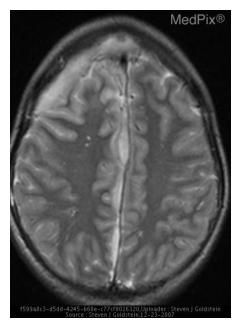

---
Q: are there abnormal findings on this image?
A: yes
VLMs: no


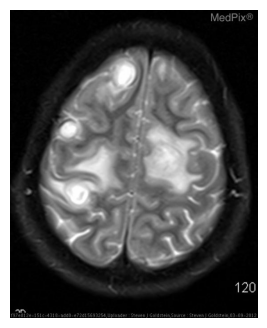

---
Q: what is the characterization of the lesion
A: ring enhancing lesion
VLMs: aponeurotic


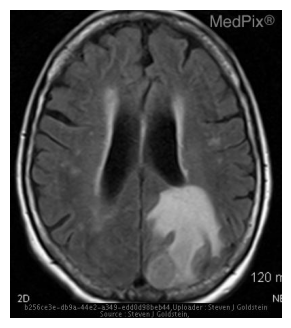

---
Q: is the mass cystic?
A: yes
VLMs: yes


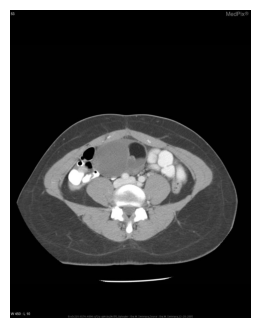

---
Q: are the clavicles fractured?
A: no
VLMs: no


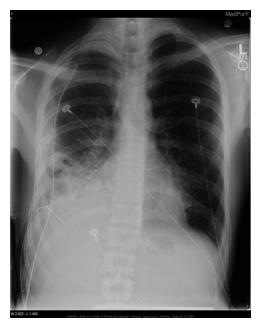

---
Q: what is the pathology?
A: left apical pneumothorax
VLMs: pleural effusion


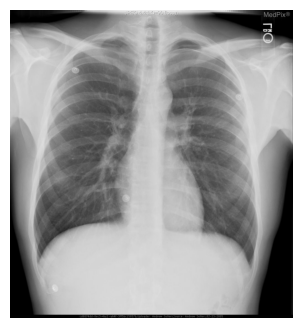

---
Q: what organ system is primarily present in this image?
A: gastrointestinal
VLMs: digestive system


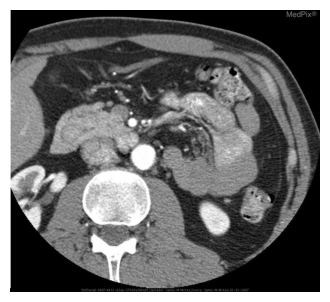

---
Q: are the costophrenic angles sharp?
A: yes
VLMs: no


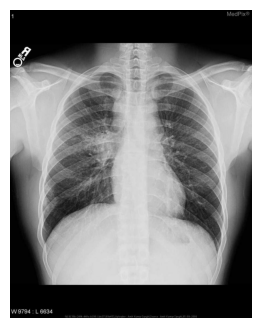

---
Q: is the liver abnormal?
A: no
VLMs: no


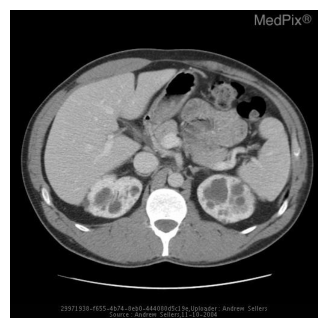

In [9]:
@torch.no_grad()
def generate_sample_outputs(
    loader: DataLoader,
    *,
    n: int = 5,
    max_new_tokens: int = 32,
 ):
    model.eval()
    shown = 0
    gen_kwargs = dict(GEN_KWARGS)
    gen_kwargs["max_new_tokens"] = max_new_tokens
    for batch in loader:
        gen_ids = model.generate(
            pixel_values=batch.pixel_values.to(device),
            input_ids=batch.input_ids.to(device),
            attention_mask=batch.attention_mask.to(device),
            **gen_kwargs,
        )
        predictions = processor.tokenizer.batch_decode(gen_ids, skip_special_tokens=True)
        predictions = [p.strip() if p.strip() else "<EMPTY>" for p in predictions]
        for i in range(len(predictions)):
            print("---")
            print("Q:", batch.raw_question[i])
            print("A:", batch.raw_answer[i])
            print("VLMs:", predictions[i])
            plt.figure(figsize=(4, 4))
            plt.imshow(batch.raw_image[i])
            plt.axis("off")
            plt.show()
            shown += 1
            if shown >= n:
                return

generate_sample_outputs(test_loader, n=9, max_new_tokens=32)

## Enhanced Evaluation Metrics

Comprehensive metrics for Med-VQA including closed-ended (accuracy, F1), open-ended (BLEU, METEOR, ROUGE, BERTScore), and calibration (ECE).

In [10]:
import time
from collections import defaultdict
from typing import Optional
import csv

try:
    from nltk.translate.meteor_score import meteor_score
    from nltk.tokenize import word_tokenize
    import nltk
    nltk.download('punkt', quiet=True)
    nltk.download('wordnet', quiet=True)
    METEOR_AVAILABLE = True
except:
    METEOR_AVAILABLE = False
    print("Warning: METEOR unavailable (nltk required)")

try:
    from rouge_score import rouge_scorer
    ROUGE_AVAILABLE = True
except:
    ROUGE_AVAILABLE = False
    print("Warning: ROUGE unavailable (rouge-score required)")

try:
    from bert_score import BERTScorer
    BERTSCORE_AVAILABLE = True
except:
    BERTSCORE_AVAILABLE = False
    print("Warning: BERTScore unavailable (bert-score required)")

def compute_closed_ended_metrics(predictions: List[str], references: List[str]) -> Dict[str, float]:
    """
    Closed-ended metrics: accuracy, precision, recall, F1, sensitivity, specificity.
    Treats prediction as binary classification (exact match).
    """
    correct = sum(normalize_text(p) == normalize_text(r) for p, r in zip(predictions, references))
    total = len(predictions)
    accuracy = correct / total if total > 0 else 0.0
    
    # Binary classification metrics (yes/no for medical VQA)
    tp = sum((normalize_text(p) == normalize_text(r) and normalize_text(r) == "yes") 
             for p, r in zip(predictions, references))
    fp = sum((normalize_text(p) == "yes" and normalize_text(r) != "yes") 
             for p, r in zip(predictions, references))
    fn = sum((normalize_text(p) != "yes" and normalize_text(r) == "yes") 
             for p, r in zip(predictions, references))
    tn = sum((normalize_text(p) != "yes" and normalize_text(r) != "yes") 
             for p, r in zip(predictions, references))
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0
    sensitivity = recall  # Same as recall
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0
    
    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "sensitivity": sensitivity,
        "specificity": specificity,
    }

def compute_open_ended_metrics(predictions: List[str], references: List[str]) -> Dict[str, float]:
    """
    Open-ended metrics: BLEU, METEOR, ROUGE-L, BERTScore, Exact Match.
    """
    bleu = BLEU(effective_order=True)
    bleu_score = float(bleu.corpus_score(predictions, [references]).score) if predictions else 0.0
    
    exact_match = sum(normalize_text(p) == normalize_text(r) for p, r in zip(predictions, references))
    exact_match = exact_match / len(predictions) if predictions else 0.0
    
    metrics = {
        "bleu": bleu_score,
        "exact_match": exact_match,
    }
    
    # METEOR
    if METEOR_AVAILABLE:
        try:
            meteor_scores = [meteor_score([word_tokenize(r)], word_tokenize(p)) 
                           for p, r in zip(predictions, references)]
            metrics["meteor"] = float(np.mean(meteor_scores))
        except:
            metrics["meteor"] = 0.0
    
    # ROUGE-L
    if ROUGE_AVAILABLE:
        try:
            scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
            rouge_scores = [scorer.score(r, p)['rougeL'].fmeasure 
                          for p, r in zip(predictions, references)]
            metrics["rouge_l"] = float(np.mean(rouge_scores))
        except:
            metrics["rouge_l"] = 0.0
    
    # BERTScore
    if BERTSCORE_AVAILABLE:
        try:
            scorer = BERTScorer(lang="en", rescale_with_baseline=True)
            P, R, F1 = scorer.score(predictions, references)
            metrics["bertscore_f1"] = float(F1.mean())
        except:
            metrics["bertscore_f1"] = 0.0
    
    return metrics

def compute_expected_calibration_error(
    predictions: List[str],
    references: List[str],
    confidences: Optional[List[float]] = None,
    n_bins: int = 10,
) -> float:
    """
    Expected Calibration Error (ECE): measures alignment between confidence and accuracy.
    If confidences not provided, assumes uniform confidence = 1.0
    """
    if confidences is None:
        confidences = [1.0] * len(predictions)
    
    correct = [normalize_text(p) == normalize_text(r) for p, r in zip(predictions, references)]
    
    bin_boundaries = np.linspace(0, 1, n_bins + 1)
    ece = 0.0
    
    for i in range(n_bins):
        bin_lower = bin_boundaries[i]
        bin_upper = bin_boundaries[i + 1]
        
        in_bin = [(bin_lower <= c < bin_upper) or (i == n_bins - 1 and c == 1.0) 
                  for c in confidences]
        
        if sum(in_bin) > 0:
            bin_acc = sum(c for c, ib in zip(correct, in_bin) if ib) / sum(in_bin)
            bin_conf = sum(c for c, ib in zip(confidences, in_bin) if ib) / sum(in_bin)
            bin_weight = sum(in_bin) / len(predictions)
            ece += bin_weight * abs(bin_acc - bin_conf)
    
    return float(ece)

@torch.no_grad()
def comprehensive_evaluation(
    model: torch.nn.Module,
    loader: DataLoader,
    *,
    max_new_tokens: int = 32,
    log_latency: bool = True,
) -> Dict[str, Any]:
    """
    Run comprehensive evaluation with all metrics + latency logging.
    """
    model.eval()
    
    all_predictions: List[str] = []
    all_refs: List[str] = []
    all_questions: List[str] = []
    all_images: List[Image.Image] = []
    
    gen_kwargs = dict(GEN_KWARGS)
    gen_kwargs["max_new_tokens"] = max_new_tokens
    
    # Track inference latency
    latencies = []
    
    for batch in tqdm(loader, desc="Evaluating"):
        t0 = time.time()
        
        gen_ids = model.generate(
            pixel_values=batch.pixel_values.to(device),
            input_ids=batch.input_ids.to(device),
            attention_mask=batch.attention_mask.to(device),
            **gen_kwargs,
        )
        
        if log_latency:
            torch.cuda.synchronize() if torch.cuda.is_available() else None
            latencies.append(time.time() - t0)
        
        predictions = processor.tokenizer.batch_decode(gen_ids, skip_special_tokens=True)
        predictions = [p.strip() if p.strip() else "<EMPTY>" for p in predictions]
        refs = [str(r) for r in batch.raw_answer]
        
        all_predictions.extend(predictions)
        all_refs.extend(refs)
        all_questions.extend(batch.raw_question)
        all_images.extend(batch.raw_image)
    
    # Compute metrics
    closed_metrics = compute_closed_ended_metrics(all_predictions, all_refs)
    open_metrics = compute_open_ended_metrics(all_predictions, all_refs)
    ece = compute_expected_calibration_error(all_predictions, all_refs)
    
    results = {
        **closed_metrics,
        **open_metrics,
        "ece": ece,
    }
    
    if log_latency and latencies:
        results["mean_latency_s"] = float(np.mean(latencies))
        results["std_latency_s"] = float(np.std(latencies))
        results["throughput_samples_per_s"] = len(all_predictions) / sum(latencies)
    
    if torch.cuda.is_available():
        results["peak_vram_gb"] = torch.cuda.max_memory_allocated() / 1e9
    
    # Store raw data for further analysis
    results["_raw_predictions"] = all_predictions
    results["_raw_references"] = all_refs
    results["_raw_questions"] = all_questions
    results["_raw_images"] = all_images
    
    return results

# Run comprehensive evaluation
print("Running comprehensive evaluation on validation set...")
val_results = comprehensive_evaluation(model, val_loader, log_latency=True)

print("Running comprehensive evaluation on test set...")
test_results = comprehensive_evaluation(model, test_loader, log_latency=True)

# Print results
print("\n=== Validation Results ===")
for k, v in val_results.items():
    if not k.startswith("_"):
        print(f"  {k}: {v:.4f}" if isinstance(v, float) else f"  {k}: {v}")

print("\n=== Test Results ===")
for k, v in test_results.items():
    if not k.startswith("_"):
        print(f"  {k}: {v:.4f}" if isinstance(v, float) else f"  {k}: {v}")

Running comprehensive evaluation on validation set...


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:32<00:00,  2.08it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Running comprehensive evaluation on test set...


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:33<00:00,  2.01it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



=== Validation Results ===
  accuracy: 0.4424
  precision: 0.5761
  recall: 0.7571
  f1: 0.6543
  sensitivity: 0.7571
  specificity: 0.8040
  bleu: 7.2407
  exact_match: 0.4424
  meteor: 0.0000
  rouge_l: 0.4828
  bertscore_f1: 0.6700
  ece: 0.5576
  mean_latency_s: 0.4122
  std_latency_s: 0.1630
  throughput_samples_per_s: 9.5961
  peak_vram_gb: 9.0961

=== Test Results ===
  accuracy: 0.4015
  precision: 0.6623
  recall: 0.6711
  f1: 0.6667
  sensitivity: 0.6711
  specificity: 0.8653
  bleu: 4.4331
  exact_match: 0.4015
  meteor: 0.0000
  rouge_l: 0.4424
  bertscore_f1: 0.6115
  ece: 0.5985
  mean_latency_s: 0.4263
  std_latency_s: 0.1634
  throughput_samples_per_s: 9.2789
  peak_vram_gb: 9.0961


## Per-Question-Type Analysis

Break down metrics by question type (e.g., "modality", "organ", "abnormality") to identify model strengths and weaknesses.

In [11]:
def categorize_question_type(question: str) -> str:
    """
    Simple heuristic to categorize Med-VQA questions.
    Customize for your dataset's question taxonomy.
    """
    q_lower = question.lower()
    
    # Common medical VQA question categories
    if any(word in q_lower for word in ["what", "which", "where"]):
        if "modality" in q_lower or "imaging" in q_lower:
            return "modality"
        elif any(organ in q_lower for organ in ["brain", "heart", "lung", "liver", "kidney"]):
            return "organ"
        elif "abnormal" in q_lower or "disease" in q_lower or "condition" in q_lower:
            return "abnormality"
        else:
            return "what_other"
    elif any(word in q_lower for word in ["is", "does", "can", "are"]):
        return "yes_no"
    elif "how many" in q_lower or "count" in q_lower:
        return "counting"
    else:
        return "other"

def compute_per_question_type_metrics(
    predictions: List[str],
    references: List[str],
    questions: List[str],
) -> Dict[str, Dict[str, float]]:
    """
    Compute metrics grouped by question type.
    """
    # Group by question type
    by_type = defaultdict(lambda: {"predictions": [], "references": []})
    
    for p, r, q in zip(predictions, references, questions):
        qtype = categorize_question_type(q)
        by_type[qtype]["predictions"].append(p)
        by_type[qtype]["references"].append(r)
    
    # Compute metrics for each type
    type_metrics = {}
    for qtype, data in by_type.items():
        preds = data["predictions"]
        refs = data["references"]
        
        closed = compute_closed_ended_metrics(preds, refs)
        open_m = compute_open_ended_metrics(preds, refs)
        
        type_metrics[qtype] = {
            **closed,
            **open_m,
            "count": len(preds),
        }
    
    return type_metrics

# Analyze test set by question type
test_type_metrics = compute_per_question_type_metrics(
    test_results["_raw_predictions"],
    test_results["_raw_references"],
    test_results["_raw_questions"],
)

print("\n=== Per-Question-Type Metrics (Test Set) ===")
for qtype, metrics in sorted(test_type_metrics.items()):
    print(f"\n{qtype.upper()} (n={metrics['count']}):")
    for k, v in metrics.items():
        if k != "count":
            print(f"  {k}: {v:.4f}" if isinstance(v, float) else f"  {k}: {v}")

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You sho


=== Per-Question-Type Metrics (Test Set) ===

ABNORMALITY (n=10):
  accuracy: 0.0000
  precision: 0.0000
  recall: 0.0000
  f1: 0.0000
  sensitivity: 0.0000
  specificity: 1.0000
  bleu: 9.2748
  exact_match: 0.0000
  meteor: 0.0000
  rouge_l: 0.1633
  bertscore_f1: 0.2031

MODALITY (n=5):
  accuracy: 0.6000
  precision: 0.0000
  recall: 0.0000
  f1: 0.0000
  sensitivity: 0.0000
  specificity: 1.0000
  bleu: 40.2192
  exact_match: 0.6000
  meteor: 0.0000
  rouge_l: 0.6000
  bertscore_f1: 0.6835

ORGAN (n=7):
  accuracy: 0.1429
  precision: 0.0000
  recall: 0.0000
  f1: 0.0000
  sensitivity: 0.0000
  specificity: 1.0000
  bleu: 15.9274
  exact_match: 0.1429
  meteor: 0.0000
  rouge_l: 0.1429
  bertscore_f1: 0.1795

OTHER (n=12):
  accuracy: 0.7500
  precision: 1.0000
  recall: 1.0000
  f1: 1.0000
  sensitivity: 1.0000
  specificity: 1.0000
  bleu: 40.0892
  exact_match: 0.7500
  meteor: 0.0000
  rouge_l: 0.7500
  bertscore_f1: 0.7440

WHAT_OTHER (n=79):
  accuracy: 0.0886
  precision: 

## Human Evaluation Workflow

Export model predictions to CSV for manual annotation and qualitative analysis.

In [12]:
def export_predictions_for_human_eval(
    predictions: List[str],
    references: List[str],
    questions: List[str],
    images: List[Image.Image],
    output_csv: Path,
    n_samples: Optional[int] = None,
) -> None:
    """
    Export predictions to CSV for human evaluation.
    Each row contains: question, reference, prediction, and a placeholder for human score.
    """
    if n_samples is not None:
        indices = np.random.choice(len(predictions), min(n_samples, len(predictions)), replace=False)
    else:
        indices = range(len(predictions))
    
    with open(output_csv, "w", newline="", encoding="utf-8") as f:
        writer = csv.writer(f)
        writer.writerow([
            "sample_id",
            "question",
            "reference_answer",
            "model_prediction",
            "question_type",
            "human_correctness_score",  # 0=incorrect, 1=partially_correct, 2=correct
            "human_relevance_score",  # 0=irrelevant, 1=somewhat_relevant, 2=relevant
            "human_clarity_score",  # 0=unclear, 1=somewhat_clear, 2=clear
            "human_notes",
        ])
        
        for i in indices:
            qtype = categorize_question_type(questions[i])
            writer.writerow([
                i,
                questions[i],
                references[i],
                predictions[i],
                qtype,
                "",  # To be filled by human annotator
                "",
                "",
                "",
            ])
    
    print(f"Exported {len(list(indices))} samples to {output_csv} for human evaluation.")
    print("Annotators should fill in: human_correctness_score, human_relevance_score, human_clarity_score, human_notes")

# Export test set predictions for human evaluation
HUMAN_EVAL_DIR = Path("human_eval")
HUMAN_EVAL_DIR.mkdir(exist_ok=True)

export_predictions_for_human_eval(
    predictions=test_results["_raw_predictions"],
    references=test_results["_raw_references"],
    questions=test_results["_raw_questions"],
    images=test_results["_raw_images"],
    output_csv=HUMAN_EVAL_DIR / "test_predictions_for_annotation.csv",
    n_samples=50,  # Export 50 random samples (or all if fewer)
)

print(f"\nHuman evaluation CSV saved. Next steps:")
print("1. Open the CSV and manually annotate each prediction")
print("2. Load the annotated CSV back to compute inter-rater agreement and human-aligned metrics")

Exported 50 samples to human_eval/test_predictions_for_annotation.csv for human evaluation.
Annotators should fill in: human_correctness_score, human_relevance_score, human_clarity_score, human_notes

Human evaluation CSV saved. Next steps:
1. Open the CSV and manually annotate each prediction
2. Load the annotated CSV back to compute inter-rater agreement and human-aligned metrics


## Evaluation / Sample Outputs


Show a few qualitative generations from the test split to confirm the pipeline is producing plausible outputs.